# Suppliment: Why Perceptually-Uniform Colormaps are important

See Also:

- https://predictablynoisy.com/makeitpop-intro
- https://bids.github.io/colormap/

In [7]:
import makeitpop
import numpy as np
import matplotlib.pyplot as plt

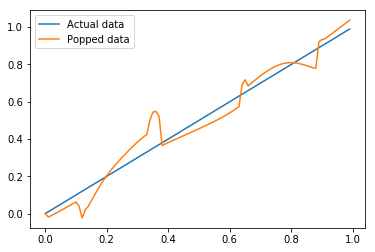

In [18]:
# Pop the data!
data = np.arange(0, 1, .01)
data_more_publishable = makeitpop.makeitpop(data, colormap='jet', scaling_factor=50)

fig, ax = plt.subplots()
ax.plot(data, data, label="Actual data")
ax.plot(data, data_more_publishable, label="Popped data")
ax.legend()

In [17]:
derivatives, derivatives_scaled = makeitpop.update_derivatives(makeitpop.cmaps + ['gist_ncar'])